In this notebook, I am going to explore stock price prediction using four methods:
  
  * Linear Regression using L2 regularization or **Ridge Regression**
  * Lasso
  * LARSLasso
  * Gradient Boosting Regressors
  
The source of the stock prices is from Yahoo Finance. I downloaded stock prices for Microsoft since September 8th 2010 until September 6th, 2019. The variable to predict is the Adjusted Close price.

I am running this on Google Colab, and switch runtime to GPU so it will train much faster

Let's import all the necessary packages we need, which include NumPy, Pandas, Matplotlib, Scikit-learn and Keras/Tensorflow.

In [1]:
# Import necessar packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


I have downloaded the Microsoft stock price data to my computer from Yahoo Finance. After that I uploaded the csv file in my github repository, got the raw url and used Pandas to read in the data and set the independent variable to be the Date. Let's also take a look at the first few entries

In [0]:
url = 'https://raw.githubusercontent.com/v17539/stock-prediction/master/MSFT.csv'
df = pd.read_csv(url)

In [3]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-09-08,24.070000,24.200001,23.740000,23.930000,19.175180,65512400
2010-09-09,24.190001,24.209999,23.990000,24.010000,19.239281,46028900
2010-09-10,23.980000,24.030001,23.790001,23.850000,19.111082,58284300
2010-09-13,24.200001,25.290001,24.090000,25.110001,20.120724,114680400
2010-09-14,25.040001,25.350000,24.889999,25.030001,20.056620,87160400


Let's take a look at how the prices look each day since the beginning up to the point where the data on the x-axis as nteh price on the y-axis

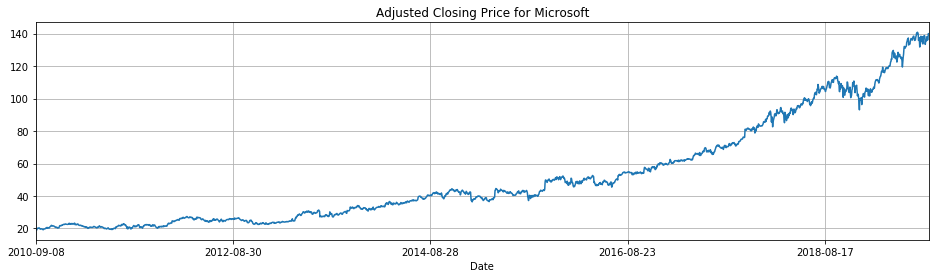

In [4]:
df['Adj Close'].plot(label='MSFT', figsize=(16,4), title='Adjusted Closing Price for Microsoft', grid=True)



To make this more robust to noise and to leverage past values, we will not use the date to predict the stock prices, but we will use batches of 32 prices where each training example, we leverage 32 prices from the past to predict the price on the 33rd day. We will thus have $N - 32$ training examples with $N$ being the number of days we've downloaded for the stock data. We will thus create a 2D matrix of training samples with each row being the prices 32 consecutive days in the past with the price to predict being the current day.


In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 days windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices]  # Create the 2D matrix of training samples

We create a 2D matrix such that we have 33 columns per example. The training samples will be the first 32 columns with the target variable being the last column.

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1]  # Each output value represents the 33rd day

Perform train/test split such that the first 80% of the prices is the training set and the last 20% of the prices is the test dataset. We will train on the training set and test the performance on the test set to see how well we can forecast the price for Microsoft stock.

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]


# Method #1 - Ridge Regression

We will use the Ridge Regression method from Scikit-learn where we'll train and perform inference on the training and test data respectively. Let's also plot how it compares with the actual data for both training and test.


In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

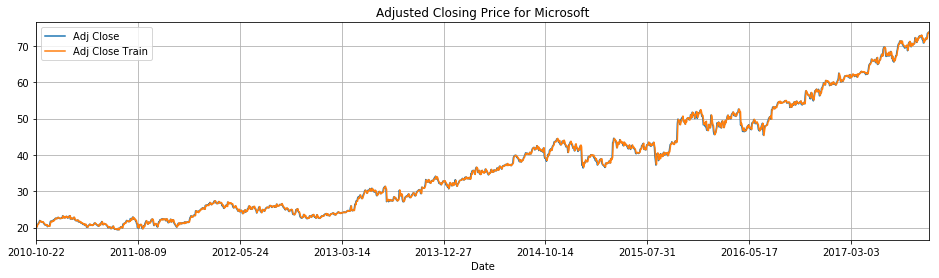

In [12]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='MSFT', figsize=(16,4), title='Adjusted Closing Price for Microsoft', grid=True)



OK... not bad and very frighteningly close. We may be overfitting. Let's check out the test data.

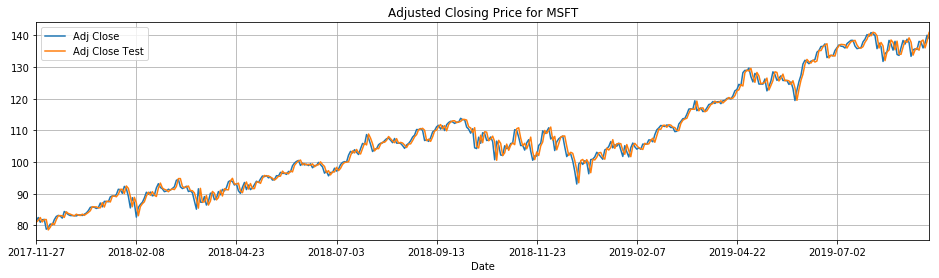

In [15]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:]
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='MSFT', figsize=(16,4), title='Adjusted Closing Price for MSFT', grid=True)


Method #2 - Lasso

The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. For this reason Lasso and its variants are fundamental to the field of compressed sensing. Under certain conditions, it can recover the exact set of non-zero coefficients


In [16]:
# Train
lasso_model = linear_model.Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Infer
y_pred_train_lasso = lasso_model.predict(X_train)
y_pred_lasso = lasso_model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.36997230286397, tolerance: 43.09403493713618
  positive)


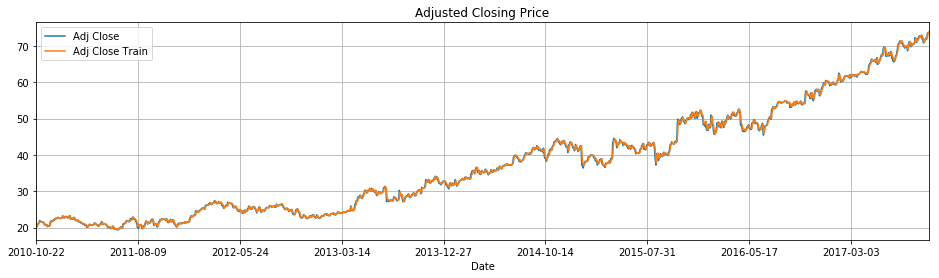

In [17]:


# Plot what it looks like for the training data
df_lasso = df.copy()
df_lasso.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_lasso = df_lasso.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_lasso['Adj Close Train'] = y_pred_train_lasso[:-window_size]
df_lasso.plot(label='MSFT', figsize=(16,4), title='Adjusted Closing Price', grid=True)



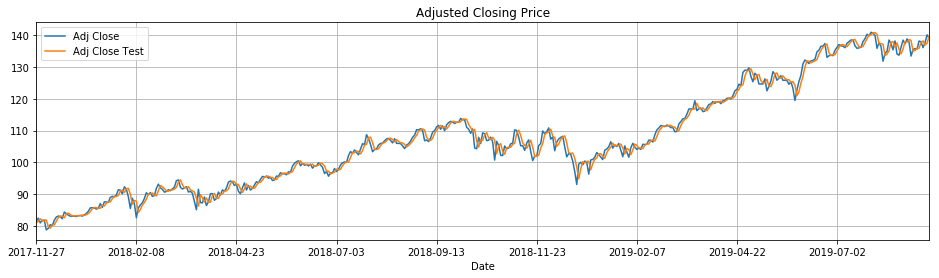

In [18]:
# Same for the test
df_lasso = df.copy()
df_lasso.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_lasso = df_lasso.iloc[ind_split+window_size:]
df_lasso['Adj Close Test'] = y_pred_lasso
df_lasso.plot(label='MSFT', figsize=(16,4), title='Adjusted Closing Price', grid=True)


# Method #3 - LARS Lasso

LassoLars is a lasso model implemented using the LARS algorithm, and unlike the implementation based on coordinate descent, this yields the exact solution, which is piecewise linear as a function of the norm of its coefficients.


In [0]:
# Train
larslasso_model = linear_model.LassoLars(alpha=.1)
larslasso_model.fit(X_train, y_train)

# Infer
y_pred_train_larslasso = larslasso_model.predict(X_train)
y_pred_larslasso = larslasso_model.predict(X_test)

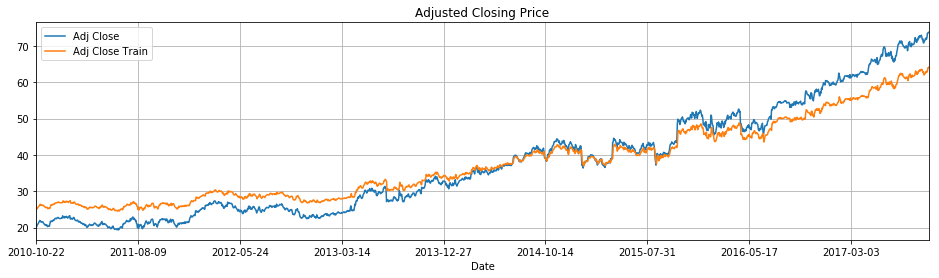

In [20]:
# Plot what it looks like for the training data
df_larslasso = df.copy()
df_larslasso.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_larslasso = df_larslasso.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_larslasso['Adj Close Train'] = y_pred_train_larslasso[:-window_size]
df_larslasso.plot(label='MSI', figsize=(16,4), title='Adjusted Closing Price', grid=True)

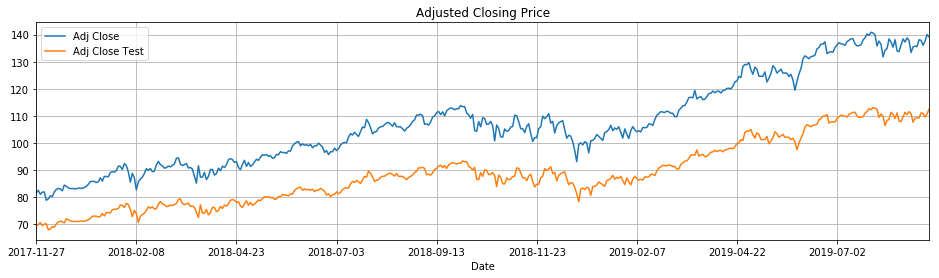

In [21]:

# Same for the test
df_larslasso = df.copy()
df_larslasso.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_larslasso = df_larslasso.iloc[ind_split+window_size:]
df_larslasso['Adj Close Test'] = y_pred_larslasso
df_larslasso.plot(label='MSI', figsize=(16,4), title='Adjusted Closing Price', grid=True)



# Method #4 - Gradient Boosting Trees

Let's apply the same methodology from Method #1 to Gradient Boosting Trees in Scikit-learn.


In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

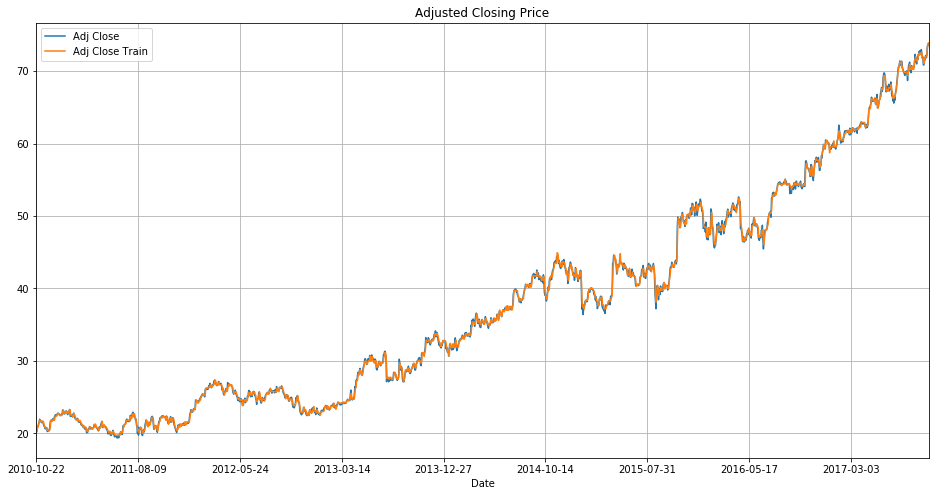

In [24]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='MSFT', figsize=(16,8), title='Adjusted Closing Price', grid=True)


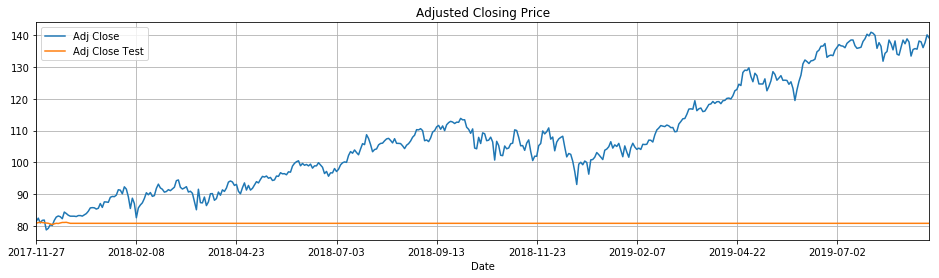

In [25]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] 
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='MSI', figsize=(16,4), title='Adjusted Closing Price', grid=True)

